# Credit card fraud detection

In [22]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, accuracy_score,classification_report
from imblearn.combine import SMOTETomek 
from sklearn.ensemble import RandomForestClassifier # Random forest classifier
from time import time
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, accuracy_score,classification_report
from imblearn.combine import SMOTETomek 
from time import time
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from imblearn.combine import SMOTEENN
from sklearn.metrics import accuracy_score, confusion_matrix, accuracy_score,classification_report
from sklearn.svm import SVC
from xgboost import XGBClassifier
#import lightgbm as lgb


In [23]:
dataset = pd.read_csv('creditcard.csv')
dataset.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### The distribution of genuine and fraudulent transactions

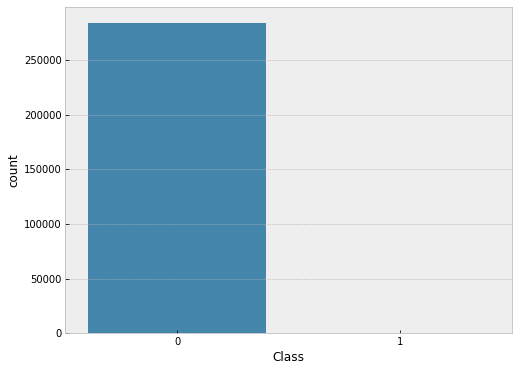

In [36]:
plt.figure(figsize=(8, 6))
plt.style.use('bmh')
sns.countplot(x='Class', data=dataset)
plt.show()

### The distribution of fraudulent and genuine transactions based on time

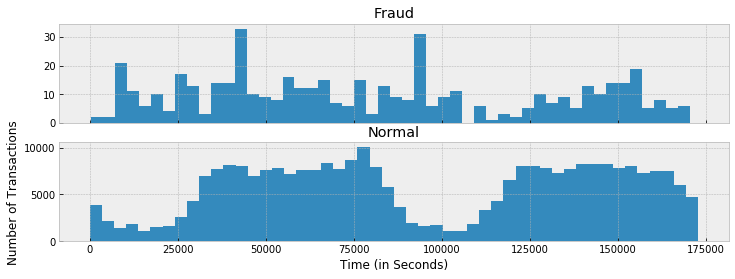

In [5]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
bins = 50
ax1.hist(dataset.Time[dataset.Class == 1], bins = bins)
ax1.set_title('Fraud')
ax2.hist(dataset.Time[dataset.Class == 0], bins = bins)
ax2.set_title('Normal')
plt.xlabel('Time (in Seconds)')
plt.ylabel('Number of Transactions')
plt.show()

### The distribution of fraudulent and genuine transactions based on amounts

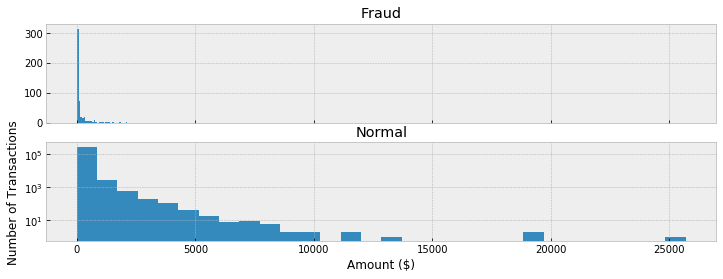

In [6]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
bins = 30
ax1.hist(dataset.Amount[dataset.Class == 1], bins = bins)
ax1.set_title('Fraud')
ax2.hist(dataset.Amount[dataset.Class == 0], bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

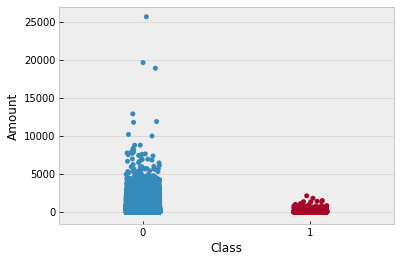

In [9]:
ax = sns.stripplot(x=dataset.Class, y=dataset.Amount, data= dataset, jitter=True)
plt.show()

In [2]:
dataset['TimeGroup'] =(dataset.Time.astype('float')/3600).round(decimals=0)
dataset.tail()


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V22,V23,V24,V25,V26,V27,V28,Amount,Class,TimeGroup
284802,172786.0,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0,48.0
284803,172787.0,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,...,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0,48.0
284804,172788.0,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,...,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0,48.0
284805,172788.0,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,...,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.00,0,48.0
284806,172792.0,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,...,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,217.00,0,48.0


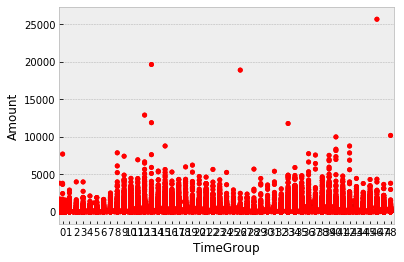

In [56]:
#f, (ax0, ax1) = plt.subplots(2, 1, sharex=True, figsize=(12,4))
#ax0 = sns.regplot(x=dataset.TimeGroup.astype(int), y=dataset.Amount[dataset.Class == 1],
#                    palette="Set2", data= dataset, jitter=True)
#ax1 = sns.regplot(x=dataset.TimeGroup.astype(int), y=dataset.Amount[dataset.Class == 0], 
#                    palette="Set2", data= dataset, jitter=True)
#ax1 = sns.stripplot(x=dataset.Class, y=dataset.Amount, data= dataset, jitter=True)
ax0 = sns.swarmplot(x=dataset.TimeGroup.astype(int), y=dataset.Amount[dataset.Class == 1], data=dataset, color = 'red')
plt.show()

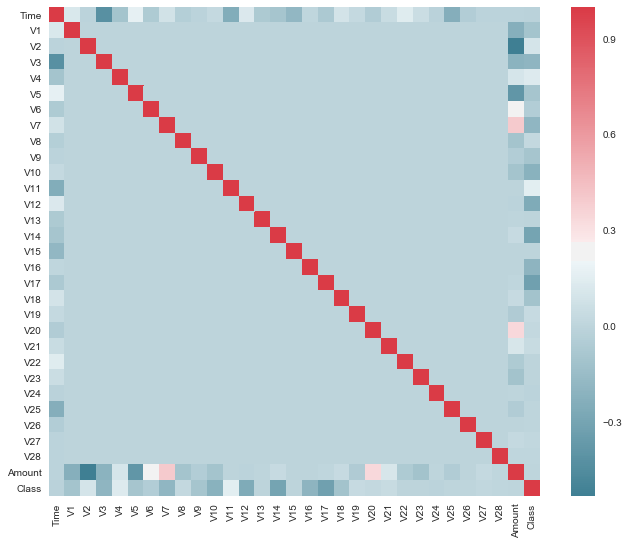

In [17]:
sns.set(style="white")
corr = dataset.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap = cmap,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

### fraund and geniune data

In [24]:
dataset['normAmount'] = StandardScaler().fit_transform(dataset['Amount'].values.reshape(-1, 1))
datasetNew = dataset.drop(['Time','Amount'],axis=1)
datasetNew.tail()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,normAmount
284802,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,4.356170,...,0.213454,0.111864,1.014480,-0.509348,1.436807,0.250034,0.943651,0.823731,0,-0.350151
284803,-0.732789,-0.055080,2.035030,-0.738589,0.868229,1.058415,0.024330,0.294869,0.584800,-0.975926,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,0,-0.254117
284804,1.919565,-0.301254,-3.249640,-0.557828,2.630515,3.031260,-0.296827,0.708417,0.432454,-0.484782,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,0,-0.081839
284805,-0.240440,0.530483,0.702510,0.689799,-0.377961,0.623708,-0.686180,0.679145,0.392087,-0.399126,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,0,-0.313249
284806,-0.533413,-0.189733,0.703337,-0.506271,-0.012546,-0.649617,1.577006,-0.414650,0.486180,-0.915427,...,0.261057,0.643078,0.376777,0.008797,-0.473649,-0.818267,-0.002415,0.013649,0,0.514355


### Fraud and geniune data

In [25]:
Fraud = datasetNew[datasetNew["Class"]==1]
Normal = datasetNew[datasetNew["Class"]==0]
len(Fraud)
len(Normal)
#X = datasetNew.drop(['Class'], axis = 1)
#y = datasetNew[['Class']].copy()
Fraud_features= Fraud.loc[:,Fraud.columns != "Class"]
Fraud_labels= Fraud.loc[:,Fraud.columns=="Class"]
x_Fraud_train, x_Fraud_test, y_Fraud_train, y_Fraud_test = train_test_split(Fraud_features,
                                                                    Fraud_labels, test_size = 0.30, random_state = 0)
Normal_features= Normal.loc[:,Normal.columns != "Class"]
Normal_labels= Normal.loc[:,Normal.columns=="Class"]
x_Normal_train, x_Normal_test, y_Normal_train, y_Normal_test = train_test_split(Normal_features,
                                                                    Normal_labels, test_size = 0.30, random_state = 0)
X_train = np.concatenate([x_Fraud_train, x_Normal_train])
y_train = np.concatenate([y_Fraud_train, y_Normal_train])
X_test = np.concatenate([x_Fraud_test, x_Normal_test])
y_test = np.concatenate([y_Fraud_test, y_Normal_test])
print("length of training data")
print(len(x_Fraud_train))
print("length of test data")
print(len(x_Normal_test))

length of training data
344
length of test data
85295


### The data is imbalanced so it must be up or down sampled.

In [26]:
sm = SMOTETomek()
X_resampled_rf, y_resampled_rf = sm.fit_sample(X_train, y_train)

In [41]:
def HyperParam(X_train,y_train, X_test, y_test):
   # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)
 #   smote = SMOTETomek(random_state = 0)
    #smote = SMOTEENN(random_state = 0)
    pipeline = Pipeline([
             #  ('smote', smote),
               ('clf', RandomForestClassifier(n_estimators = 100)),
                ])

    parameters = {
             # 'clf__n_estimators': (100,150),
              'clf__class_weight':('balanced_subsample','balanced'),
              'clf__max_features': ('auto', 'sqrt', 'log2'),
             }

    gs_clf = GridSearchCV(estimator=pipeline, param_grid=parameters, 
                          n_jobs=-1, verbose=1, cv = 3, scoring = 'recall')
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    gs_clf.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % gs_clf.best_score_)
    print("Best parameters set:")
    best_parameters = gs_clf.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
        #### Cross-validation to check the test set error rate
    scores = cross_val_score(gs_clf, X_train, y_train, scoring='neg_mean_absolute_error')
    print(scores)
    
    
    ## Predicting the test set results
    y_pred = gs_clf.predict(X_test)
    
    print("The accuracy score of {0}".format(accuracy_score(y_test, y_pred)))
    print ('Confusion Matrix:')
    print (confusion_matrix(y_test, y_pred))
    print (accuracy_score(y_test, y_pred))
    print (classification_report(y_test, y_pred))
    return y_test, y_pred, X_train

### Random Forest 

In [42]:
y_ov_test, y_ov_pred, X_train = HyperParam(X_resampled_rf,y_resampled_rf, X_test, y_test)

Performing grid search...
('pipeline:', ['clf'])
parameters:
{'clf__max_features': ('auto', 'sqrt', 'log2'), 'clf__class_weight': ('balanced_subsample', 'balanced')}
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 11.1min finished


done in 934.050s
()
Best score: 1.000
Best parameters set:
	clf__class_weight: 'balanced_subsample'
	clf__max_features: 'auto'
Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  6.9min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  7.2min finished


Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:  7.0min finished


[-1.43201688e-04 -7.53693096e-05 -9.79801025e-05]
The accuracy score of 0.999531851644
Confusion Matrix:
[[85285    10]
 [   30   118]]
0.9995318516437859
             precision    recall  f1-score   support

          0       1.00      1.00      1.00     85295
          1       0.92      0.80      0.86       148

avg / total       1.00      1.00      1.00     85443



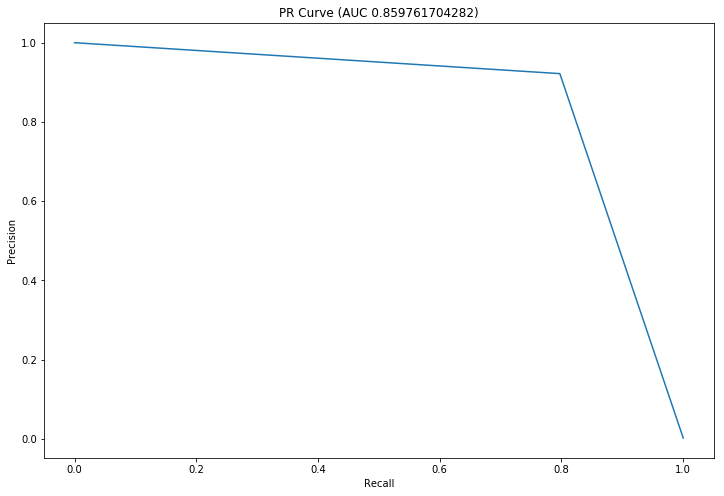

In [43]:
pr, re, _ = precision_recall_curve(y_ov_test, y_ov_pred)
plt.figure(figsize=(12,8))
plt.plot(re, pr)
plt.title('PR Curve (AUC {})'.format(auc(re, pr)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

### Feature selection with RF

In [16]:

clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_resampled_rf,y_resampled_rf)
data_features = datasetNew.drop(['Class'], axis = 1)
feature_selected = pd.Series(clf.feature_importances_,index=data_features.columns).sort_values(ascending=False)
print(feature_selected)

V14           0.189262
V10           0.128242
V4            0.103751
V17           0.093107
V11           0.091180
V12           0.069886
V16           0.052402
V3            0.045006
V2            0.033662
V7            0.029762
V8            0.015491
V9            0.013419
V1            0.012717
V5            0.010037
V20           0.009608
normAmount    0.009503
V18           0.009410
V23           0.008733
V19           0.008057
V28           0.008049
V13           0.007685
V27           0.007275
V15           0.007272
V21           0.006996
V25           0.006712
V6            0.006414
V22           0.006043
V26           0.005861
V24           0.004457
dtype: float64


### SGD Classifier
#### SMOTE technique for balancing training data set

In [4]:
from imblearn.combine import SMOTETomek
sm = SMOTETomek()
X_resampled, y_resampled = sm.fit_sample(X_train, y_train)

C:\Users\51648\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [17]:


def HyperParam_sgd(X_train,y_train, X_test, y_test):
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)
    #smote = SMOTE(random_state = 0)
    #smote = SMOTEENN(random_state = 0)
    #smote = SMOTETomek(random_state = 0)
    pipeline = Pipeline([
              # ('smote', smote),
               ('clf', SGDClassifier(max_iter=1000, tol = 0)),
                ])

    parameters = {
              'clf__loss': ('log','modified_huber','hinge'),
              'clf__penalty':('l2','elasticnet'),
              'clf__alpha': (0.00001, 0.000001),
              'clf__class_weight': (None, 'balanced'),
             }

    gs_clf = GridSearchCV(estimator=pipeline, param_grid=parameters, 
                          n_jobs=-1, verbose=1, cv = 5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    gs_clf.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % gs_clf.best_score_)
    print("Best parameters set:")
    best_parameters = gs_clf.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
        #### Cross-validation to check the test set error rate
    scores = cross_val_score(gs_clf, X_train, y_train, scoring='neg_mean_absolute_error')
    print(scores)
    
    
    ## Predicting the test set results
    y_pred = gs_clf.predict(X_test)
    
    print("The accuracy score of {0}".format(accuracy_score(y_test, y_pred)))
    print ('Confusion Matrix:')
    print (confusion_matrix(y_test, y_pred))
    print (accuracy_score(y_test, y_pred))
    print (classification_report(y_test, y_pred))
    pr, re, _ = precision_recall_curve(y_test, y_pred)
    plt.figure(figsize=(12,8))
    plt.plot(re, pr)
    plt.title('PR Curve (AUC {})'.format(auc(re, pr)))
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    return y_test, y_pred, X_train

Performing grid search...
('pipeline:', ['clf'])
parameters:
{'clf__penalty': ('l2', 'elasticnet'), 'clf__loss': ('log', 'modified_huber', 'hinge'), 'clf__class_weight': (None, 'balanced'), 'clf__alpha': (1e-05, 1e-06)}
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  3.3min finished


done in 201.239s
()
Best score: 0.941
Best parameters set:
	clf__alpha: 1e-05
	clf__class_weight: None
	clf__loss: 'log'
	clf__penalty: 'l2'
Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   40.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.8min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.5s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  1.9min finished


Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   42.6s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:  2.2min finished


[-0.06270727 -0.05526831 -0.05715255]
The accuracy score of 0.969008578819
Confusion Matrix:
[[82657  2638]
 [   10   138]]
0.9690085788186277
             precision    recall  f1-score   support

          0       1.00      0.97      0.98     85295
          1       0.05      0.93      0.09       148

avg / total       1.00      0.97      0.98     85443



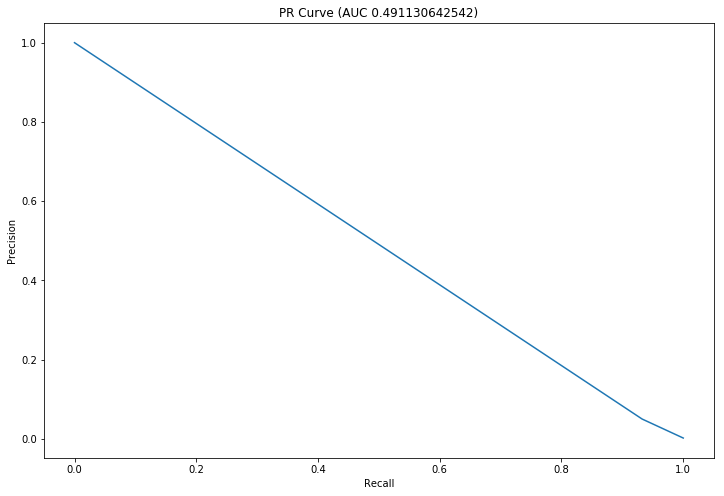

In [19]:
y_sgd_test, y_sgd_pred, X_train = HyperParam_sgd(X_resampled_rf,y_resampled_rf, X_test, y_test)

### SVM

In [5]:
def HyperParam_svm(X_train,y_train, X_test, y_test):
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)
    #smote = SMOTE(random_state = 0)
    #smote = SMOTEENN(random_state = 0)
    pipeline = Pipeline([
               #('smote', smote),
               ('clf', SVC(kernel = 'linear')),
                ])

    parameters = {
              'clf__class_weight': (None, 'balanced'),
             }

    gs_clf = GridSearchCV(estimator=pipeline, param_grid=parameters, 
                          n_jobs=-1, verbose=1, cv = 5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    gs_clf.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % gs_clf.best_score_)
    print("Best parameters set:")
    best_parameters = gs_clf.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
        #### Cross-validation to check the test set error rate
    scores = cross_val_score(gs_clf, X_train, y_train, scoring='neg_mean_absolute_error')
    print(scores)
    
    
    ## Predicting the test set results
    y_pred = gs_clf.predict(X_test)
    
    print("The accuracy score of {0}".format(accuracy_score(y_test, y_pred)))
    print ('Confusion Matrix:')
    print (confusion_matrix(y_test, y_pred))
    print (accuracy_score(y_test, y_pred))
    print (classification_report(y_test, y_pred))
    return y_test, y_pred, X_train

In [ ]:
y_svm_test, y_svm_pred, X_train = HyperParam_svm(X_resampled_rf,y_resampled_rf, X_test, y_test)

Performing grid search...
('pipeline:', ['clf'])
parameters:
{'clf__class_weight': (None, 'balanced')}
Fitting 5 folds for each of 2 candidates, totalling 10 fits


### XGBoost classifier

In [29]:
def HyperParam_XGB(X_train,y_train, X_test, y_test):
    #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)
    smote = SMOTE(random_state = 0)
    #smote = SMOTEENN(random_state = 0)
    pipeline = Pipeline([
               #('smote', smote),
               ('clf', XGBClassifier(eval_metric = "auc")),
                ])

    parameters = {
              'clf__n_estimators': (400,500),
              'clf__objective':("binary:logistic","binary:logitraw"),
              'clf__booster':('gbtree','dart')
             # 'clf__tree_method':('auto', 'exact', 'approx', 'hist'),
             # 'clf_alpha':(),
             # 'clf__class_weight': (None, 'balanced'),
             }

    gs_clf = GridSearchCV(estimator=pipeline, param_grid=parameters, 
                          n_jobs=-1, verbose=1, cv = 5,scoring='roc_auc')
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    print(parameters)
    t0 = time()
    gs_clf.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % gs_clf.best_score_)
    print("Best parameters set:")
    best_parameters = gs_clf.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
        #### Cross-validation to check the test set error rate
    scores = cross_val_score(gs_clf, X_train, y_train, scoring='roc_auc')
    print(scores)
    
    
    ## Predicting the test set results
    y_pred = gs_clf.predict(X_test)
    
    print("The accuracy score of {0}".format(accuracy_score(y_test, y_pred)))
    print ('Confusion Matrix:')
    print (confusion_matrix(y_test, y_pred))
    print (accuracy_score(y_test, y_pred))
    print (classification_report(y_test, y_pred))
    return y_test, y_pred, X_train

In [ ]:
y_xgb_test, y_xgb_pred, X_train = HyperParam_XGB(X_resampled_rf,y_resampled_rf, X_test, y_test)

Performing grid search...
('pipeline:', ['clf'])
parameters:
{'clf__booster': ('gbtree', 'dart'), 'clf__objective': ('binary:logistic', 'binary:logitraw'), 'clf__n_estimators': (400, 500)}
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed: 705.9min finished


done in 42885.159s
()
Best score: 1.000
Best parameters set:
	clf__booster: 'gbtree'
	clf__n_estimators: 500
	clf__objective: 'binary:logistic'
Fitting 5 folds for each of 8 candidates, totalling 40 fits


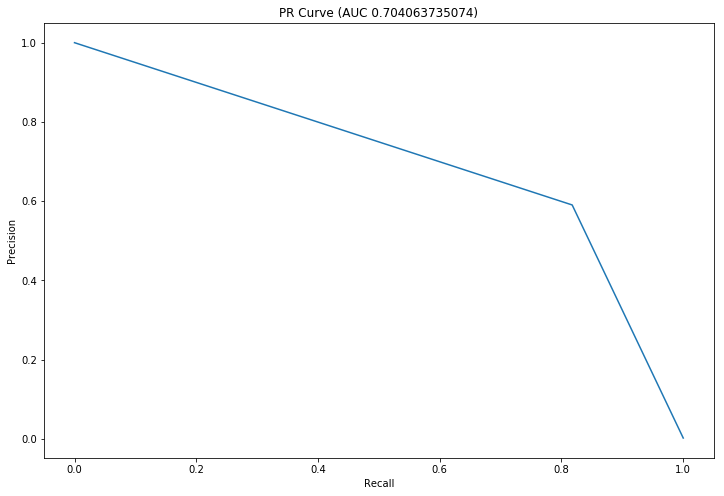

In [19]:
pr, re, _ = precision_recall_curve(y_xgb_test, y_xgb_pred)
plt.figure(figsize=(12,8))
plt.plot(re, pr)
plt.title('PR Curve (AUC {})'.format(auc(re, pr)))
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

## LightGBM